Bert finetuning

In [1]:
## Plotting history
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


In [2]:
## Plotting confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_val, y_pred, title):
    y_pred_classes = y_pred
    y_true_classes = y_val

    # Create and plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix:  ' + title)
    plt.show()



In [ ]:
!pip install datasets==2.19.2 torch==2.3.0 tensorflow==2.16.1 transformers==4.41.2

In [ ]:
!pip install pyarrow==12.0.0

In [3]:
import pandas as pd
from datasets import load_dataset

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = load_dataset('csv', data_files='/content/drive/MyDrive/EPITA/ActionLearning/HateSpeechDatasetBalanced.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 580895
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 145224
    })
})

In [ ]:
# prompt: preprocess loaded dataset for Bert finetuning, train and test separately for DatasetDict({
#     train: Dataset({
#         features: ['Content', 'Label'],
#         num_rows: 580895
#     })
#     test: Dataset({
#         features: ['Content', 'Label'],
#         num_rows: 145224
#     })
# })

from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples["Content"], truncation=True)

# Preprocess the training and test datasets
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Train and test datasets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/580895 [00:00<?, ? examples/s]

Map:   0%|          | 0/145224 [00:00<?, ? examples/s]

In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['Content', 'Label', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 580895
 }),
 Dataset({
     features: ['Content', 'Label', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 145224
 }))

In [ ]:
# prompt: save tokenized datasets

train_dataset.save_to_disk('/content/drive/MyDrive/EPITA/ActionLearning/tokenized_train_dataset')
test_dataset.save_to_disk('/content/drive/MyDrive/EPITA/ActionLearning/tokenized_test_dataset')


Saving the dataset (0/4 shards):   0%|          | 0/580895 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/145224 [00:00<?, ? examples/s]

In [4]:
# prompt: finetune bert, freeze the maximum amount of layers as possible

from transformers import BertForSequenceClassification
import torch.optim as optim  # Import optim

# Load pre-trained BERT model
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, output_attentions=False, output_hidden_states=False
)

# Freeze all layers except the last one
for param in bert_model.bert.parameters():
    param.requires_grad = False

# Unfreeze the last layer (classifier head)
for param in bert_model.classifier.parameters():
    param.requires_grad = True

# Set up optimizer (use a low learning rate for fine-tuning)
optimizer = optim.AdamW(bert_model.parameters(), lr=2e-5)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Set device (GPU if available, otherwise CPU)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# Check a parameter in the first encoder layer
print(bert_model.bert.encoder.layer[0].attention.self.query.weight.requires_grad)  # Output: False

# Check a parameter in the classifier
print(bert_model.classifier.weight.requires_grad)  # Output: True

False
True


In [ ]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# prompt: load train and test .arrow files from drive, train saved in 4 shards, test in one
from datasets import load_from_disk

# train_dataset = load_from_disk('/content/drive/MyDrive/EPITA/ActionLearning/tokenized_train_dataset')
# test_dataset = load_from_disk('/content/drive/MyDrive/EPITA/ActionLearning/tokenized_test_dataset')

loaded_train_dataset = torch.load('../../preprocessed/final_bert_train_dataset.pt')
loaded_test_dataset = torch.load('../../preprocessed/final_bert_test_dataset.pt')


In [8]:
# prompt: define train and test data loader for bert training loop
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert the train and test datasets to PyTorch tensors
train_inputs = torch.tensor(loaded_train_dataset['input_ids']).to(device)
train_masks = torch.tensor(loaded_train_dataset['attention_mask']).to(device)
train_labels = torch.tensor(loaded_train_dataset['labels']).to(device)

test_inputs = torch.tensor(loaded_test_dataset['input_ids']).to(device)
test_masks = torch.tensor(loaded_test_dataset['attention_mask']).to(device)
test_labels = torch.tensor(loaded_test_dataset['labels']).to(device)


# train_dataloader = DataLoader(
#     TensorDataset(train_inputs, train_masks, train_labels),
#     sampler=RandomSampler(train_inputs),
#     batch_size=32
# )

# test_dataloader = DataLoader(
#     TensorDataset(test_inputs, test_masks, test_labels),
#     sampler=SequentialSampler(test_inputs),
#     batch_size=32
# )


C:\Users\bemne\AppData\Local\Temp\ipykernel_6240\2974077024.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(loaded_train_dataset['input_ids']).to(device)
C:\Users\bemne\AppData\Local\Temp\ipykernel_6240\2974077024.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(loaded_train_dataset['attention_mask']).to(device)
C:\Users\bemne\AppData\Local\Temp\ipykernel_6240\2974077024.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(loaded_train_dataset['labels

In [ ]:
!pip install tqdm

In [9]:
# prompt: reduce the dataloaders to only train and test on small percent of the data
usable = 0.004
train_dataloader = DataLoader(
    TensorDataset(train_inputs[:int(len(train_inputs)*usable)], train_masks[:int(len(train_masks)*usable)], train_labels[:int(len(train_labels)*usable)]),
    sampler=RandomSampler(train_inputs[:int(len(train_inputs)*usable)]),
    batch_size=10
)

test_dataloader = DataLoader(
    TensorDataset(test_inputs[:int(len(test_inputs)*usable)], test_masks[:int(len(test_masks)*usable)], test_labels[:int(len(test_labels)*usable)]),
    sampler=SequentialSampler(test_inputs[:int(len(test_inputs)*usable)]),
    batch_size=10
)


In [10]:
# prompt: give complete model training loop:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
# Training loop
epochs = 1
history = []
for epoch in range(epochs):
    # Train
    bert_model.train()
    for batch in tqdm(train_dataloader):
        # Ensure the batch is a dictionary with correct keys
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Pass inputs to the model
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        history.append(loss.item())



100%|██████████| 233/233 [2:01:23<00:00, 31.26s/it]


In [11]:
# prompt: save finetuned bert model on drive

# Save the fine-tuned model to disk
# bert_model.save_pretrained('/content/drive/MyDrive/EPITA/ActionLearning/finetuned_bert_model')
bert_model.save_pretrained('../../models/bert_based/finetuned_bert_model')


In [12]:
# Plot the training history
# plot_training_history(history)

In [13]:
# prompt: run prediction on test data

# Run prediction on test data
bert_model.eval()
predictions, true_vals = [], []

for batch in tqdm(test_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saves memory and speeds up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true values
    predictions.append(logits)
    true_vals.append(label_ids)

print('    DONE.')


100%|██████████| 58/58 [40:48<00:00, 42.21s/it]

    DONE.


In [17]:
from sklearn.metrics import confusion_matrix, classification_report


true_vals_flat = np.concatenate(true_vals, axis=0)
predictions_flat = np.concatenate([np.argmax(p, axis=1) for p in predictions], axis=0) 


# Compute the confusion matrix
cm = confusion_matrix(true_vals_flat, predictions_flat)

# Generate a classification report
report = classification_report(true_vals_flat, predictions_flat)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[159 139]
 [110 172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       298
           1       0.55      0.61      0.58       282

    accuracy                           0.57       580
   macro avg       0.57      0.57      0.57       580
weighted avg       0.57      0.57      0.57       580



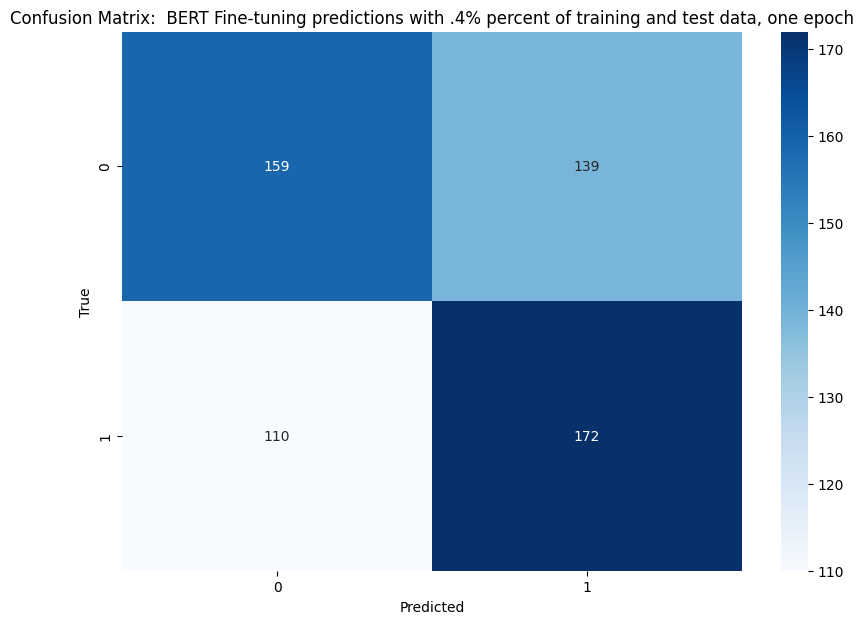

In [19]:
# Plot the confusion matrix
plot_confusion_matrix(true_vals_flat, predictions_flat, "BERT Fine-tuning predictions with .4% percent of training and test data, one epoch")

In [ ]:
# prompt: save finetuned bert model on drive

# Save the fine-tuned model to disk
bert_model.save_pretrained('/content/drive/MyDrive/EPITA/ActionLearning/finetuned_bert_model')


## Finetuning BERT model

In [ ]:
import pickle
from torch.utils.data import DataLoader

# Load datasets
with open("../../preprocessed/bert_mendeley_train_dataset.pkl", "rb") as train_file:
    train_dataset = pickle.load(train_file)

with open("../../preprocessed/bert_mendeley_val_dataset.pkl", "rb") as val_file:
    val_dataset = pickle.load(val_file)

# Create DataLoader for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [ ]:
## Prepare bert model
import torch
from transformers import BertForSequenceClassification, AdamW

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
## Train and validate the model
from tqdm import tqdm
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            token_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_samples
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the model
model.save_pretrained('../../models/bert_mendeley_model/model')
tokenizer.save_pretrained('../../models/bert_mendeley_model/tokenizer')

# Save training history
history = {
    'loss': train_losses,
    'val_loss': val_losses,
    'accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}
with open("../../histories/bert_mendeley_finetuned_history.pkl", "wb") as f:
    pickle.dump(history, f)

print("Training completed and model saved successfully.")


In [ ]:
## plot training history
import matplotlib.pyplot as plt
import pickle

# Load training history
with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load pre-trained BERT model
model_path = "../../models/bert_mendeley_model/model"
model = BertForSequenceClassification.from_pretrained(model_path)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load validation data (assuming you have val_dataset)
val_input_ids, val_attention_mask, val_labels = val_dataset.values()

# Predictions
with torch.no_grad():
    logits = model(val_input_ids, attention_mask=val_attention_mask).logits
    predicted_labels = torch.argmax(logits, dim=1)

# Create confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(val_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)

In [ ]:
plot_training_history(history)  # Replace with your actual function

# Plot confusion matrix (use your existing function)
plot_confusion_matrix(val_labels, predicted_labels, title="Bert finetuned")  # Replace with your actual

### Gemini solution

In [ ]:
import pickle
import transformers
from datasets import load_dataset, load_metric, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Load datasets
with open("../../preprocessed/bert_mendeley_train_dataset.pkl", "rb") as train_file:
    train_dataset = pickle.load(train_file)

with open("../../preprocessed/bert_mendeley_val_dataset.pkl", "rb") as val_file:
    val_dataset = pickle.load(val_file)

# Create DataLoader for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [ ]:
train_dataset[:10]

(tensor([[ 1045,  2572,  1999,  ...,     0,     0,     0],
         [22555, 11924, 18059,  ...,     0,     0,     0],
         [ 1045,  2001,  2025,  ...,     0,     0,     0],
         ...,
         [ 8011,  2080,  2017,  ...,     0,     0,     0],
         [ 2515,  2025,  2655,  ...,     0,     0,     0],
         [ 1051,  5737,  3844,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 1]))

In [ ]:

training_args = TrainingArguments(
    output_dir="../../models/bert_mendeley_hatespeech_finetuned",
    logging_dir="../../models/bert_mendeley_hatespeech_finetuned/logs",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
)

In [ ]:
from datasets import Dataset

# Convert tensors in tuples to lists
input_features = [t[0].tolist() for t in train_dataset]
attention_masks = [t[1].tolist() for t in train_dataset]

# Create a dictionary with list values
data_dict = {'input_features': input_features, 'attention_masks': attention_masks}

# Convert to Hugging Face Dataset
train_data = Dataset.from_dict(data_dict)


In [ ]:
# Convert tensors in tuples to lists for validation data
val_input_features = [t[0].tolist() for t in val_dataset]
val_attention_masks = [t[1].tolist() for t in val_dataset]

# Create a dictionary with list values
val_data_dict = {'input_features': val_input_features, 'attention_masks': val_attention_masks}

# Convert to Hugging Face Dataset
val_data = Dataset.from_dict(val_data_dict)


In [ ]:

# Define the evaluation metric
metric = load_metric("glue", "mrpc")

# Define the evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)



c:\Users\bemne\anaconda3\envs\al\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


In [ ]:

# prompt: save the history of bert as training accuracy, train loss, val accuracy, val loss, plot the accuracy and loss separately, then computer confusion matrix and plot that too

# Save the history of bert as training accuracy, train loss, val accuracy, val loss
history = trainer.state.history

# Plot the accuracy and loss separately
import matplotlib.pyplot as plt

plt.plot(history["train_accuracy"], label="train_accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Compute confusion matrix and plot that too
from sklearn.metrics import confusion_matrix

y_pred = trainer.predict(val_data).predictions.argmax(-1)
y_true = val_data["labels"]

cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()